In [13]:
# %load HiddenMarkovModel.py
import numpy as np
from notes_utilities import randgen, log_sum_exp, normalize_exp, normalize

/Users/gokceyucel/Boun/ml/midterm2-gokceyucel/HiddenMarkovModel.py:16: RuntimeWarning: divide by zero encountered in log
  self.logB = np.log(self.B)
/Users/gokceyucel/Boun/ml/midterm2-gokceyucel/HiddenMarkovModel.py:17: RuntimeWarning: divide by zero encountered in log
  self.logA = np.log(self.A)
/Users/gokceyucel/Boun/ml/midterm2-gokceyucel/HiddenMarkovModel.py:50: RuntimeWarning: divide by zero encountered in log
  return lstar + np.log(np.dot(self.A,np.exp(lp-lstar)))
/Users/gokceyucel/Boun/ml/midterm2-gokceyucel/HiddenMarkovModel.py:54: RuntimeWarning: divide by zero encountered in log
  return lstar + np.log(np.dot(np.exp(lp-lstar), self.A))


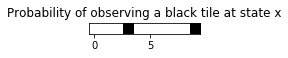

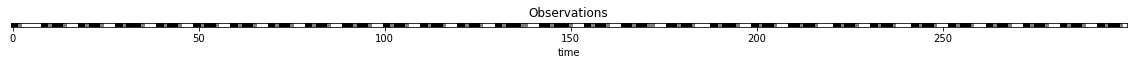

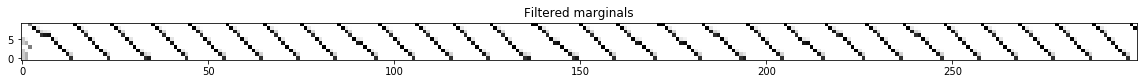

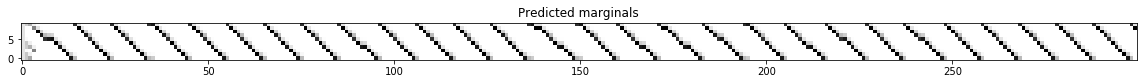

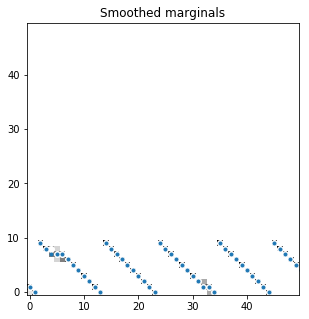

In [46]:
import numpy as np

from HiddenMarkovModel import *
import matplotlib.pylab as plt

# Number of tiles
S = 10

# Probability of staying on the same tile
ep = 0.1

# Probability of making an arbitrary jump
kidnap = 0.0

# Probability of correct observation
a = 0.9

# Set up the transition matrix
idx = [i for i in range(1,S)]+[0]
I = np.diag(np.ones(S))
A = (1-kidnap)*(ep*I + (1-ep)*I[:,idx]) + kidnap*np.ones((S,S))/S

C = np.zeros((2,S))

# Set up the observation matrix
c = a*np.random.randint(0,2, S) + (1-a)*np.ones(S)/2
C = np.array([c,1-c])

# Prior
p0 = np.ones(S)/S
#p0 = np.random.rand(S)
p0 = p0/sum(p0)

#hm2 = HMM(p0, A2, C)


%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from IPython import display
import time

# Define transition matrix
transition_matrix = np.zeros(shape=(10,10))

for i in range (10):
    j = i
    if j < 9:
        transition_matrix[i][j] = 0.1
        transition_matrix[i][j+1] = 0.9
    else:
        transition_matrix[i][j] = 0.1
        transition_matrix[i][0] = 0.9

observation_probabilities = np.array([
                    [0.3, 0.0],
                    [0.0, 0.2],
                    [0.7, 0.8]])

# Define observations
#observations = ['g', 'g', 'g', 'w', 'g', 'g', 'k', 'k', 'k', 'w', 'g', 'g', 'w']
observations = ['g', 'g', 'g', 'w', 'g', 'g', 'k', 'k', 'k', 'w']

# Numeric observations represented as: 
# [0,0,1] for 'g' (green)
# [0,1,0] for 'w' (white)
# [1,0,0] for 'k' (black)

# Define observation matrix
observation_matrix = np.zeros(shape=(3,len(observations)))

for i in range (len(observations)):
    if   observations[i] == 'k':
        observation_matrix[0,i] = 1
    elif observations[i] == 'w':
        observation_matrix[1,i] = 1
    else:
        observation_matrix[2,i] = 1

# Tile colours are represented as:
# [1,0] for 'k' (black) 
# [0,1] for 'w' (white)

tiles = ['K', 'K', 'W', 'K', 'W', 'W', 'K', 'W', 'W', 'K']
#tiles = ['K', 'K', 'W', 'K', 'W', 'W', 'K', 'W', 'W', 'K', 'K', 'K', 'W']

# Define tiles matrix
tile_matrix = np.zeros(shape=(2,len(tiles)))

for i in range (len(tiles)):
    if tiles[i] == 'K':
        tile_matrix[0,i] = 1
    else: 
        tile_matrix[1,i] = 1
   
T = 500
xs = list()
#hm = HMM(p0, A, C)

# doğru sıralama bu elelme
A = transition_matrix
C = observation_matrix
hm = HMM(p0, A, C)

y,x = hm.generate_sequence(300)

log_alpha, log_alpha_pred = hm.forward(y)
log_gamma = hm.forward_backward_smoother(y)
xs = hm.viterbi(y)

alpha = normalize_exp(log_alpha, axis=0)
alpha_pred = normalize_exp(log_alpha_pred, axis=0)
gam = normalize_exp(log_gamma, axis=0)


plt.figure(figsize=(hm.S//5,1))
plt.imshow(C[1,:].reshape(1,hm.S), interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.set_yticks([])
ax.invert_yaxis()
plt.title('Probability of observing a black tile at state x')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(y.reshape(1,len(y)), interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.set_yticks([])
ax.invert_yaxis()
plt.title('Observations')
plt.xlabel('time')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(alpha, interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.invert_yaxis()
plt.title('Filtered marginals')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(alpha_pred, interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.invert_yaxis()
plt.title('Predicted marginals')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(gam, interpolation='nearest', cmap='gray_r')
plt.plot(xs,'wo')
plt.plot(x,'.')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim((-0.5,T/10-0.5))
ax.set_ylim((-0.5,T/10-0.5))
plt.title('Smoothed marginals')

plt.show()